# Recommender Systems
Implementing the Matrix Factorization algorithm.

# Part 1. Matrix Factorization

For this part, we will:

* load and process the MovieLens 1M dataset,
* build a matrix factorization model,
* evaluate the model.

To start out, we need to prepare the data. We will use the MovieLens 1M data from https://grouplens.org/datasets/movielens/1m/ in this homework.

In [5]:
import pandas as pd
import numpy as np

data_df = pd.read_csv('./ratings.dat', sep='::',
                      names=["UserID", "MovieID", "Rating", "Timestamp"],
                      engine='python')
data_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
# Counting unique users, unique movies, and total ratings
unique_users = data_df['UserID'].nunique()
unique_movies = data_df['MovieID'].nunique()
total_ratings = data_df['Rating'].count()

# Printing the results
unique_users, unique_movies, total_ratings

(6040, 3706, 1000209)

Because in Python, the index for a list starts from 0, it is more convenient if we have the ids of users and movies start from 0 as well. Moreover, we also need to make sure the UserID and MovieID are consecutive.

In [7]:
# First, generate dictionaries for mapping old id to new id for users and movies
unique_MovieID = data_df['MovieID'].unique()
unique_UserID = data_df['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_MovieID:
    movie_old2new_id_dict[i] = j
    j += 1

# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
for j in range(len(data_df)):
    data_df.at[j, 'UserID'] = user_old2new_id_dict[data_df.at[j, 'UserID']]
    data_df.at[j, 'MovieID'] = movie_old2new_id_dict[data_df.at[j, 'MovieID']]

data_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


Now, you have got a ready-to-use dataset. The next step is to split it **randomly** into training and testing sets so that you can build your recommendation model based on the training set and evaluate it on the testing set. Here you need to split the data_df into two parts: a DataFrame **train_df** containing 70% user-movie-rating samples in data_df, and a DataFrame **test_df** containing 30% samples. train_df and test_df should have no overlap. In the next cell, write your code and print the numbers of samples in the generated train_df and test_df at last.

**Note that here we just have training and testing sets without using a validation set for the sake of simplicity.**

In [8]:
# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
# Your Code Here...
# Set random seed for reproducibility
np.random.seed(42)

# Shuffle the indices of the DataFrame
shuffled_indices = np.random.permutation(len(data_df))

# Split indices for training (70%) and testing (30%)
train_size = int(len(data_df) * 0.7)
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

# Use the indices to split the DataFrame
train_df = data_df.iloc[train_indices].reset_index(drop=True)
test_df = data_df.iloc[test_indices].reset_index(drop=True)
# End of your code

print('num of train_df = ' + str(len(train_df)))
print('num of test_df = ' + str(len(test_df)))

num of train_df = 700146
num of test_df = 300063


Last, we need to generate numpy array variables (i.e., matrix version of dataset) for both train_df and test_df for the ease of calculation in the next step. More specifically, we will generate two numpy array variables of size (#user by #movie) with each entry representing the user-movie rating. And if the user-movie rating is missing, then the corresponding entry is 0. 

In [9]:
from scipy.sparse import coo_matrix

num_user = len(data_df['UserID'].unique())
num_movie = len(data_df['MovieID'].unique())

train_mat = coo_matrix((train_df['Rating'].values, (train_df['UserID'].values, train_df['MovieID'].values)),
                       shape=(num_user, num_movie)).toarray().astype(float)
test_mat = coo_matrix((test_df['Rating'].values, (test_df['UserID'].values, test_df['MovieID'].values)),
                      shape=(num_user, num_movie)).toarray().astype(float)


With the processed data, let's implement the matrix factorization (MF for short) model. The MF model can be mathematically represented as:

<center>$\underset{\mathbf{P},\mathbf{Q}}{\text{min}}\,\,L=\sum_{(u,i)\in\mathcal{O}}(\mathbf{P}_u\cdot\mathbf{Q}^\top_i-r_{u,i})^2+\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$,</center>
    
where $\mathbf{P}$ is the user latent factor matrix of size (#user, #latent); $\mathbf{Q}$ is the movie latent factor matrix of size (#movie, #latent); $\mathcal{O}$ is a user-movie pair set containing all user-movie pairs having ratings in train_mat; $r_{u,i}$ represents the rating for user u and movie i; $\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$ is the regularization term to overcome overfitting problem, $\lambda$ is the regularization weight (a hyper-parameter manually set by developer, i.e., you), and $\lVert\mathbf{P}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{P}_{x,y})^2$, $\lVert\mathbf{Q}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{Q}_{x,y})^2$. Such an L function is called the **loss function** for the matrix factorization model. The goal of training an MF model is to find appropriate $\mathbf{P}$ and $\mathbf{Q}$ to minimize the loss L.

To implement such an MF, here we will write a Python class for the model. There are three functions in this MF class: init, train, and predict.

* The 'init' function (**already provided**) is to initialize the variables the MF class needs, which takes 5 inputs: train_mat, test_mat, latent, lr, and reg. 'train_mat' and 'test_mat' are the corresponfing training and testing matrices we have. 'latent' represents the latent dimension we set for the MF model. 'lr' represents the learning rate, i.e., the update step in each optimization iteration, default is 0.01. 'reg' represents the regularization weight, i.e., the $\lambda$ in the MF formulation.

* The 'train' function (**partially provided and need to complete**) is to train the MF model given the training data train_mat. There is only one input to this function: an int variable 'epoch' to indicate how many epochs for training the model. The main body of this function should be a loop for 'epoch' iterations. In each iteration, following the algorithm to update the MF model:

        1. Randomly shuffle training user-movie pairs  (i.e., user-movie pairs having ratings in train_mat)
        2. Have an inner loop to iterate each user-movie pair:
                a. given a user-movie pair (u,i), update the user latent factor and movie latent factor by gradient decsent:    
<center>$\mathbf{P}^\prime_u=\mathbf{P}_u-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{Q}_i+2\lambda\mathbf{P}_u]$</center>    
<center>$\mathbf{Q}^\prime_i=\mathbf{Q}_i-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{P}_u+2\lambda\mathbf{Q}_i]$</center>    
<center>where $\mathbf{P}_u$ and $\mathbf{Q}_i$ are row vectors of size (1, #latent), $\gamma$ is learning rate (default is 0.01), $\lambda$ is regularization weight.</center>
        
        3. After iterating over all user-movie pairs, we have finished the training for the current epoch. Now calculate and print out the value of the loss function L after this epoch, and the RMSE on test_mat by the current MF model. Then append them to lists to keep a record of them.
The train function needs to return two lists: 'epoch_loss_list' recording the loss after each training epoch, and 'epoch_test_RMSE_list' recording the RMSE on test_mat after each training epoch. The calculation of RMSE is formulated as:
<center>$RMSE=\sqrt{\frac{1}{|\mathcal{O}_{test}|}\sum_{(u,i)\in\mathcal{O}_{test}}(\mathbf{P}_u\cdot\mathbf{Q}^\top_i-r_{u,i})^2}$</center>
<center>where $\mathcal{O}_{test}$ is a user-movie pair set containing all user-movie pairs having ratings in test_mat, and $|\mathcal{O}_{test}|$ represents the total number of user-movie pairs in test_mat.</center>

* The 'predict' function (**already provided**) is to calculate the prediction_mat by the learned $\mathbf{P}$ and $\mathbf{Q}$.


In [10]:
class MF:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)

        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function

        self.num_user, self.num_movie = train_mat.shape

        # get the user-movie pairs having ratings in train_mat
        # self.train_user stores user ids, self.train_movie stores movie ids.
        self.train_user, self.train_movie = self.train_mat.nonzero()

        self.num_train = len(self.train_user)  # the number of user-movie pairs having ratings in train_mat

        self.train_indicator_mat = 1.0 * (train_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in train_mat
        self.test_indicator_mat = 1.0 * (test_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in test_mat

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized

    def train(self, epoch=20, verbose=True):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch
        Output: epoch_loss_list -- a list recording the training loss for each epoch
                epoch_test_RMSE_list -- a list recording the testing RMSE after each training epoch
        """
        epoch_loss_list = []
        epoch_test_RMSE_list = []
        for ep in range(epoch):
            """
            Write your code here to implement the training process for one epoch,
            and at the end of each epoch, print out the epoch number, the training loss after this epoch,
            and the test RMSE after this epoch
            """
            # start of your code
            indices = np.random.permutation(self.num_train)
            train_user_shuffled = self.train_user[indices]
            train_movie_shuffled = self.train_movie[indices]

            # Loop through shuffled user-movie pairs and update latent factors
            for u, i in zip(train_user_shuffled, train_movie_shuffled):
                rating = self.train_mat[u, i]
                pred_rating = np.dot(self.P[u], self.Q[i].T)
                error = rating - pred_rating

                # Update user and movie latent factors using gradient descent
                self.P[u] += self.lr * (error * self.Q[i] - self.reg * self.P[u])
                self.Q[i] += self.lr * (error * self.P[u] - self.reg * self.Q[i])

            # Compute training loss
            pred_train_mat = np.matmul(self.P, self.Q.T)
            train_loss = np.sum(((self.train_mat - pred_train_mat) * self.train_indicator_mat) ** 2) + \
                         self.reg * (np.sum(self.P ** 2) + np.sum(self.Q ** 2))
            epoch_loss = train_loss / np.sum(self.train_indicator_mat)

            # Compute test RMSE
            pred_test_mat = np.matmul(self.P, self.Q.T)
            test_rmse = (np.sum(((pred_test_mat - self.test_mat) * self.test_indicator_mat) ** 2) /
                         np.sum(self.test_indicator_mat)) ** 0.5

            # End of your code for this function

            epoch_loss_list.append(epoch_loss)
            epoch_test_RMSE_list.append(test_rmse)
            if verbose:
                print('Epoch={0}, Training Loss={1}, Testing RMSE={2}'.format(ep + 1, epoch_loss, test_rmse))

        return epoch_loss_list, epoch_test_RMSE_list


    def predict(self):
        prediction_mat = np.matmul(self.P, self.Q.T)
        return prediction_mat

Now, let's train an MF model based on your implementation. The code is provided, you just need to excute the next cell. The expectations are:

* first, the code can be successfully excuted without error;
* second, the training loss and RMSE on **test_mat** of each training epoch should be printed out for all 20 epochs;
* last, the best RMSE on **test_mat** should be <0.92.


In [11]:
mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=0.001)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=20)

Epoch=1, Training Loss=0.8771173076259403, Testing RMSE=0.9527735527214727
Epoch=2, Training Loss=0.8404894562094769, Testing RMSE=0.9354959115096152
Epoch=3, Training Loss=0.8301586276703067, Testing RMSE=0.9317693971276416
Epoch=4, Training Loss=0.820443877993414, Testing RMSE=0.9291760779046014
Epoch=5, Training Loss=0.8106226334513082, Testing RMSE=0.9269482471411353
Epoch=6, Training Loss=0.7953073225002218, Testing RMSE=0.9221998658506183
Epoch=7, Training Loss=0.7800130689687022, Testing RMSE=0.9170609802181863
Epoch=8, Training Loss=0.7677995705465454, Testing RMSE=0.9120517986590219
Epoch=9, Training Loss=0.7556188091597315, Testing RMSE=0.9074839714932564
Epoch=10, Training Loss=0.747104769848709, Testing RMSE=0.9053649652383712
Epoch=11, Training Loss=0.7395779085611831, Testing RMSE=0.9039088091153309
Epoch=12, Training Loss=0.7324019955938464, Testing RMSE=0.9016873393699
Epoch=13, Training Loss=0.7278831056981634, Testing RMSE=0.9012473688448605
Epoch=14, Training Loss=0.

# Part 2: Tune Hyper-parameters in Matrix Factorization (30 points)

In Part 1, we train an MF model with latent dimension set as 5, regularization weight as 0.001, training epoch as 20. However, it is not clear whether these are good choices or not. Hence, in this part, we will tune these hyper-parameters to train an effective model.

A most straightforward but powerful method is to grid search each hyper-parameter and find the best one based on the RMSE on test_mat. In this part, we will do the grid search for train epoch, latent dimension, and regularization weight.

### Tune training epoch

For training epoch, we only need to run the experiment of MF for one time, and record the test RMSE for each epoch and find the epoch that produces the best test RMSE. To visually show the change of test RMSE corresponding to the training epoch, we can plot the test RMSE for each epoch in a figure as shown in the next cell.

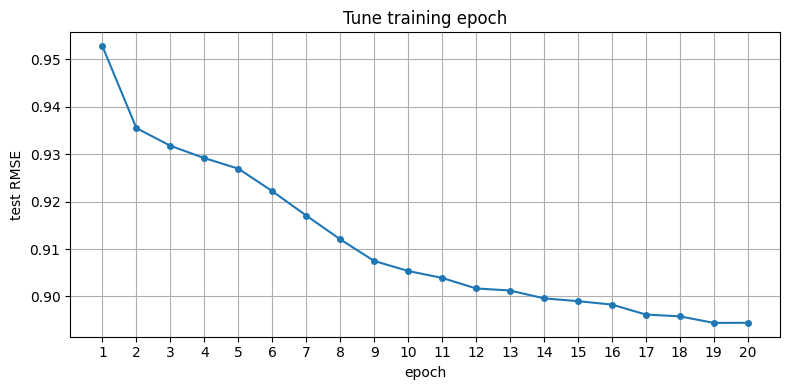

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(np.arange(len(epoch_test_RMSE_list)) + 1, epoch_test_RMSE_list, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks(np.arange(len(epoch_test_RMSE_list)) + 1)
ax.set_ylabel('test RMSE')
ax.set_xlabel('epoch')
ax.set_title('Tune training epoch')
ax.grid(True)
plt.tight_layout()
plt.show()

### Tune latent dimension

By this figure, you can find the best epoch for your MF model. Similarly, you can plot how the test RMSE changes when you set different latent dimensions. For this, you need to run the code to initialize and train the MF model for multiple times with different settings of 'latent'. Please run the MF model with 'latent' as {1,3,5,7,9}, and plot the corresponding test RMSE for these five different latent dimensions in the next cell.

For these five runs of experiments, record the test RMSE after Ep training epochs -- Ep is the best epoch you find by the 'Tune training epoch' plot. And here, fix regularization weight as 0.001.


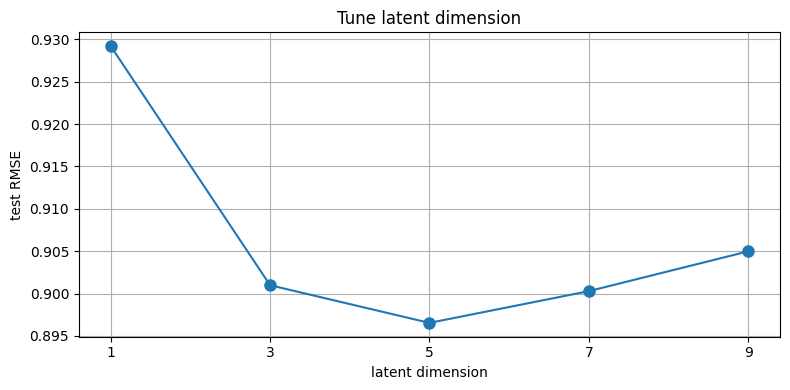

In [13]:
# Assume 'Ep' (best epoch) has been identified from the previous tuning
Ep = 15  # Example value, replace this with the actual best epoch from the epoch tuning step

# List of latent dimensions to try
latent_dimensions = [1, 3, 5, 7, 9]

# Fixed parameters
reg = 0.001
lr = 0.01

# Placeholder for test RMSE values for each latent dimension
test_rmse_list = []

# Iterate over latent dimensions and train the model
for latent in latent_dimensions:
    mf_model = MF(train_mat, test_mat, latent=latent, lr=lr, reg=reg)
    _, epoch_test_RMSE_list = mf_model.train(epoch=Ep, verbose=False)
    test_rmse_list.append(epoch_test_RMSE_list[-1])  # Append RMSE from the best epoch

# Plot test RMSE for different latent dimensions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(latent_dimensions, test_rmse_list, marker='o', linewidth=1.5, markersize=8)
ax.set_xticks(latent_dimensions)
ax.set_ylabel('test RMSE')
ax.set_xlabel('latent dimension')
ax.set_title('Tune latent dimension')
ax.grid(True)
plt.tight_layout()
plt.show()



### Tune regularization weight

Last, you can plot how the test RMSE changes when you set different regularization weight. Please run the MF model with 'reg' as {0.0001,0.0005,0.001,0.0015,0.002}, and plot corresponding test RMSE for these five different regularization weights in the next cell.

For these five runs of experiments, record the test RMSE after Ep training epochs -- Ep is the best epoch you find by the 'Tune training epoch' plot. And here, fix latent dimension as the one you find the best by the previous part.

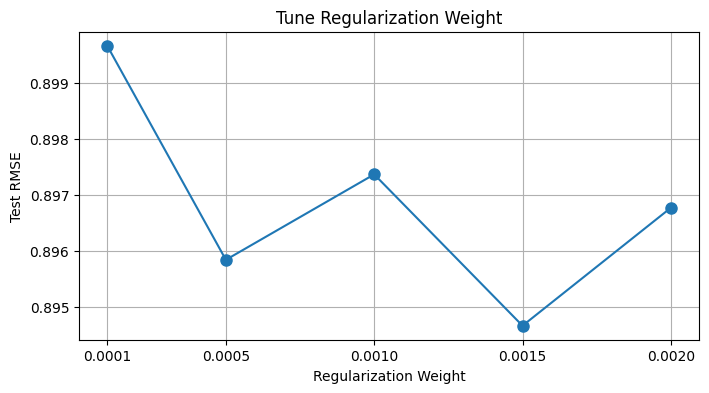

In [14]:
# Assuming `Ep` is the best epoch and `best_latent` is the optimal latent dimension
Ep = 15  # Replace with the actual best epoch from tuning
best_latent = 5  # Replace with the actual best latent dimension from tuning

# Regularization weights to test
regularization_weights = [0.0001, 0.0005, 0.001, 0.0015, 0.002]

# Fixed parameters
lr = 0.01  # Learning rate

# Placeholder for storing test RMSE values for each regularization weight
test_rmse_list = []

# Iterate over each regularization weight
for reg in regularization_weights:
    # Initialize the MF model with the current regularization weight and best latent dimension
    mf_model = MF(train_mat, test_mat, latent=best_latent, lr=lr, reg=reg)

    # Train the model for the best epoch count
    _, epoch_test_RMSE_list = mf_model.train(epoch=Ep, verbose=False)

    # Record the final test RMSE after training
    test_rmse_list.append(epoch_test_RMSE_list[-1])

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(regularization_weights, test_rmse_list, marker='o', linewidth=1.5, markersize=8)
plt.xticks(regularization_weights)
plt.xlabel('Regularization Weight')
plt.ylabel('Test RMSE')
plt.title('Tune Regularization Weight')
plt.grid(True)
plt.show()

